**HSR 22-23 Twitter JUUL Analysis**

In [ ]:
#@title packages

# VADER
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# data extract
import tweepy
!pip install tweepy --upgrade
!sudo apt-get update -y
!sudo apt-get install python3.8
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --config python3
# clear_output()
# !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
# !python3 get-pip.py --force-reinstall
# !pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip install snscrape
import snscrape.modules.twitter as sntwitter

# general ds and ml
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

# datetime
!pip install python-dateutil
import datetime
import dateutil.relativedelta as relativedelta
import os
from datetime import time
import matplotlib.dates as mdates
import time
import queue

# NLTK
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
wordnet_lemmatizer=WordNetLemmatizer()
cachedStopWords=stopwords.words("english")
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

#netowrk vis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# BERT
!pip install transformers
import torch
from torch import nn
from transformers import BertModel
from transformers import BertTokenizer
from torch.optim import Adam

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from scipy.stats import ttest_ind
from sklearn import preprocessing

# model vis
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

# random
from wordcloud import WordCloud
from collections import Counter
from pprint import pprint
import itertools

 # emotion
!pip install transformers -q
from transformers import pipeline

# tweepy
!pip install tweepy==4.10.1
import tweepy
bearer_token="AAAAAAAAAAAAAAAAAAAAAGkyiwEAAAAAZg%2BgYDDMSpEOaIRJhAE8xAh7WHU%3DUo9CYS8hssg0YUQKdqoVyDgOjuSzAVxPdQTCwDX3U05u6z5AHZ"
client=tweepy.Client(bearer_token, wait_on_rate_limit=True)

# drive
from IPython.display import clear_output 
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data'
clear_output()
ROOT_PATH='/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/'

In [ ]:
#@title tweepy
# #PRIVATE remove when share/upload git
# #tweepy stuff 
# bearer_token="AAAAAAAAAAAAAAAAAAAAAGkyiwEAAAAAZg%2BgYDDMSpEOaIRJhAE8xAh7WHU%3DUo9CYS8hssg0YUQKdqoVyDgOjuSzAVxPdQTCwDX3U05u6z5AHZ"
# client=tweepy.Client(bearer_token, wait_on_rate_limit=True)

# #Gets original english tweets using the JUUL hashtag

# #https://docs.tweepy.org/en/latest/client.html#search-tweets
# #https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
# #https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-all
# juul_hashtag_raw_tweets=[]
# for response in tweepy.Paginator(client.search_recent_tweets, 
#     query = '"juuling" -is:retweet lang:en',
#     user_fields = ['description','entities','id','location','name','protected','public_metrics','url','username','verified'],
#     tweet_fields = ['author_id','context_annotations','conversation_id','created_at','edit_controls','entities','geo','id','in_reply_to_user_id','lang','public_metrics','possibly_sensitive','referenced_tweets','reply_settings','source','text'],
#     expansions = ['author_id','entities.mentions.username','geo.place_id','in_reply_to_user_id','referenced_tweets.id','referenced_tweets.id.author_id'],
#     start_time = '2022-10-27T00:00:00Z',
#     sort_order = 'relevancy',
#     max_results=10):

#   time.sleep(1)
#   juul_hashtag_raw_tweets.append(response)

In [ ]:
#@title Construct information cascade
all_retweets=pd.concat([pd.read_csv('all_retweets_list_2016.csv'),pd.read_csv('all_retweets_list_2017.csv'),pd.read_csv('all_retweets_list_2018.csv'),pd.read_csv('all_retweets_list_2019.csv'),pd.read_csv('all_retweets_list_2020.csv'),pd.read_csv('all_retweets_list_2021.csv'),pd.read_csv('all_retweets_list_2022.csv')],ignore_index=True)
all_following_list=pd.concat([pd.read_csv('all_following_list_2016.csv'),pd.read_csv('all_following_list_2017.csv'),pd.read_csv('all_following_list_2018.csv'),pd.read_csv('all_following_list_2019.csv'),pd.read_csv('all_following_list_2020.csv'),pd.read_csv('all_following_list_2021.csv'),pd.read_csv('all_following_list_2022.csv')],ignore_index=True)
all_retweets=all_retweets[~all_retweets.isin(all_retweets[~all_retweets['RetweeterUserUsername'].isin(pd.merge(all_following_list,all_retweets,left_on='UserUsername',right_on='RetweeterUserUsername',how='inner').drop_duplicates('UserUsername')['RetweeterUserUsername'].tolist())]['TweetID'].tolist())]
all_retweets=pd.concat([pd.read_csv('all_retweets_list_2016.csv'),pd.read_csv('all_retweets_list_2017.csv'),pd.read_csv('all_retweets_list_2018.csv'),pd.read_csv('all_retweets_list_2019.csv'),pd.read_csv('all_retweets_list_2020.csv'),pd.read_csv('all_retweets_list_2021.csv'),pd.read_csv('all_retweets_list_2022.csv')],ignore_index=True)

res_dict=construct_tree(
    pd.merge(all_retweets,all_tweets_df[['TweetID','TweeterUsername']],on='TweetID').sort_values('RetweetDate',ascending=True),
    all_following_list.groupby('UserUsername')['FollowingUsername'].unique())

graph={}
for tweet_id,connections in res_dict.items():
  graph[tweet_id]={}
  for con_from,con_to in connections.items():
    if con_to not in graph[tweet_id]:
      graph[tweet_id][con_to]=[con_from]
    else:
      graph[tweet_id][con_to].append(con_from)

    if con_from not in graph[tweet_id]:
      graph[tweet_id][con_from]=[con_to]
    else:
      graph[tweet_id][con_from].append(con_to)

tree_features={}
for tweet_id,tree in tqdm(graph.items()):
  num_nodes,cascade_size,cascade_scale,cascade_depth,structural_virality,visited=traverse_tree(tree,all_tweets_df.set_index('TweetID').loc[tweet_id]['TweeterUsername'])
  tree_features[tweet_id]={
      'n': int(num_nodes),
      'm': int(cascade_size),
      'd1': int(cascade_scale),
      'h': int(cascade_depth),
      'structural_virality': float(structural_virality),
      'depth': visited
  }

min_max_scaler = preprocessing.MinMaxScaler()
working=pd.DataFrame(tree_features).T
working=working[working['n']>1]
working['normalized_structural_virality']=min_max_scaler.fit_transform(working[['structural_virality']])

with open('retweet_graph.pkl', 'wb') as f:
    pickle.dump(graph,f)
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

working.to_csv('retweet_graph_features.csv')
working=pd.read_csv('retweet_graph_features.csv')

100%|██████████| 245/245 [15:18<00:00,  3.75s/it]


100%|██████████| 245/245 [00:00<00:00, 95183.82it/s]


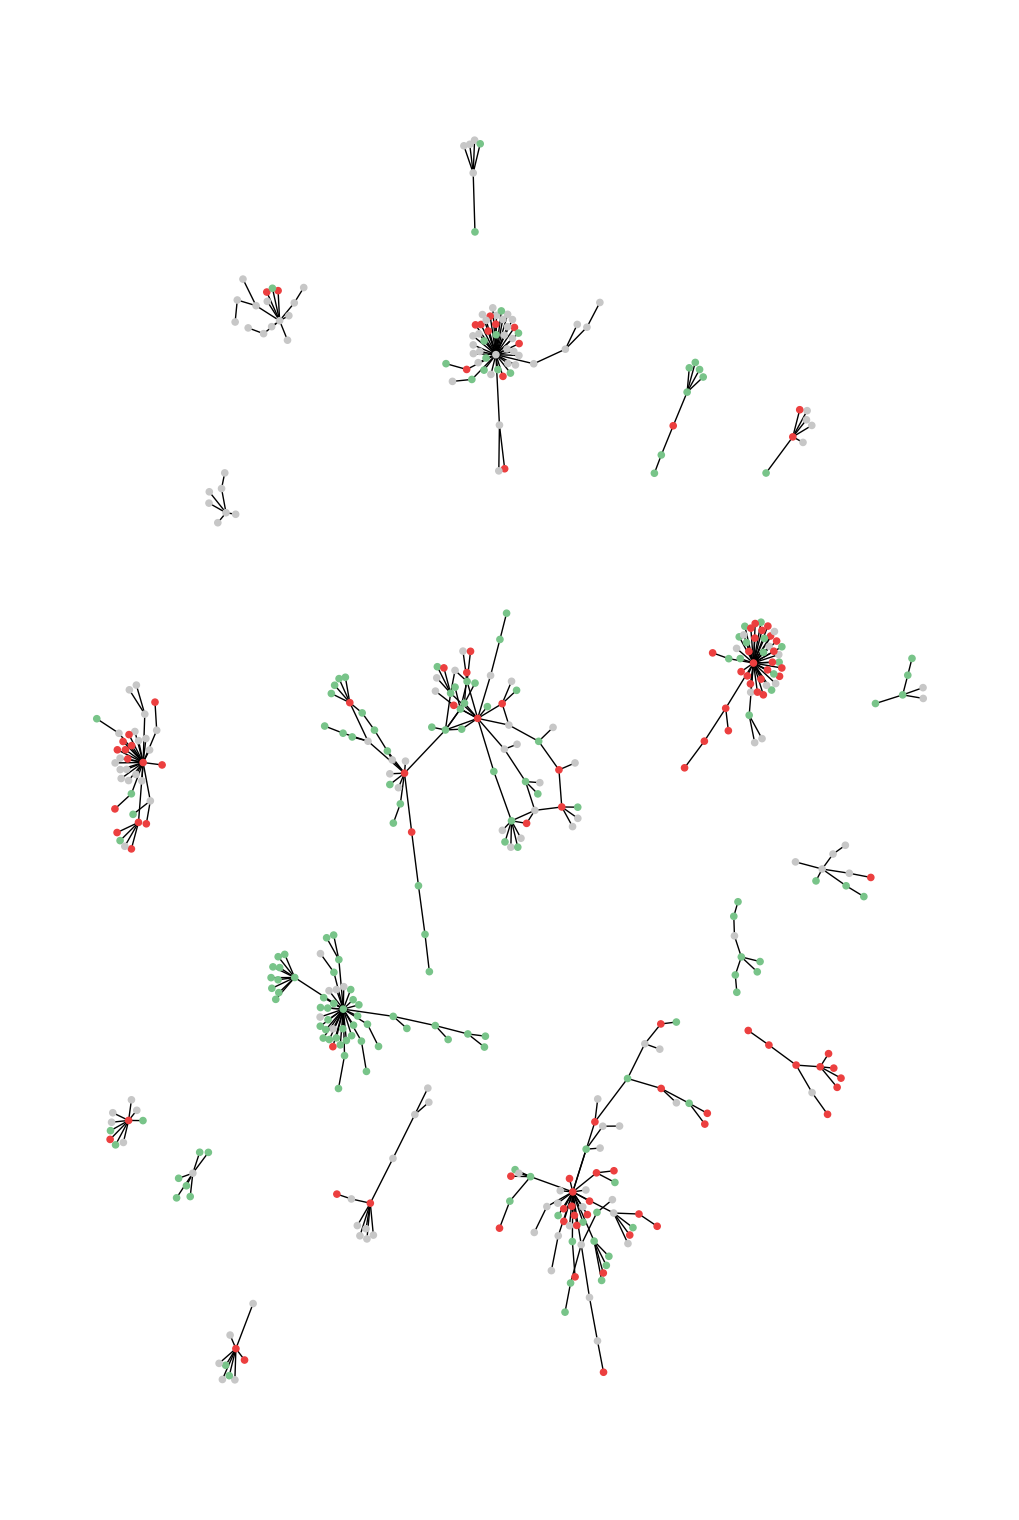

In [ ]:
#@title Information cascades
id_list,from_list,to_list=[],[],[]
for key,value in tqdm(graph.items()):
  for key2,value2 in value.items():
    for value3 in value2:
      id_list.append(key)
      from_list.append(key2)
      to_list.append(value3)

graph_df=pd.DataFrame({'TweetID': id_list,'From':from_list,'To':to_list})
graph_df=graph_df[~(graph_df['From']==graph_df['To'])]
a=(graph_df.groupby('TweetID')['From'].count()<=8).reset_index()
a=a[a['From']==True]
graph_df=graph_df[~graph_df['TweetID'].isin(a['TweetID'].tolist())]

G=nx.from_pandas_edgelist(graph_df,'From','To',create_using=nx.Graph())
G.nodes()
 
nx.draw(G,with_labels=False,
        node_color=pd.Categorical(pd.concat([all_tweets_df[all_tweets_df['TweetID'].isin(graph.keys())][['TweeterUsername','VADER_sentiment_class']],all_retweets[['RetweeterUserUsername','VADER_sentiment_class']].rename({'RetweeterUserUsername':'TweeterUsername'},axis=1)],ignore_index=True).drop_duplicates('TweeterUsername').set_index('TweeterUsername').reindex(G.nodes())['VADER_sentiment_class']).codes,
        cmap=mpl.colors.LinearSegmentedColormap.from_list('',['#ec3f3f','#c7c7c7','#78c489']),node_size=20,arrows=True)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

<Axes: xlabel='normalized_structural_virality', ylabel='Density'>

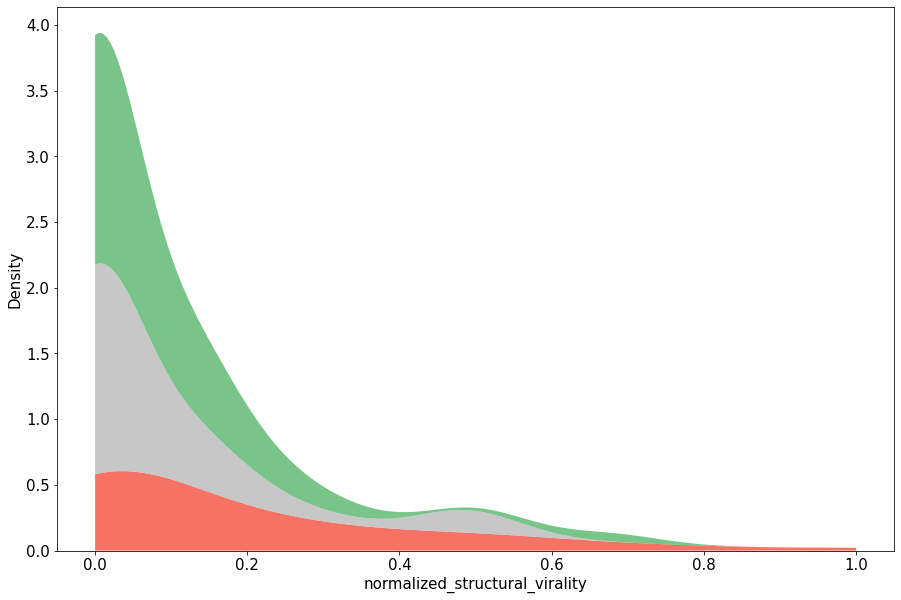

In [ ]:
#@title Normalized structural virality distrubution
palette=dict(zip([1,0,-1],list(map(mpl.colors.rgb2hex,sns.color_palette('Greens',4).as_hex()))[2:3]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Greys',4).as_hex()))[1:2]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Reds',4).as_hex()))[2:3]))

rc = {'figure.figsize':(15,10),
      'axes.facecolor':'white',
      'font.size' : 15}
plt.rcParams.update(rc)

sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.kdeplot(data=a,x='normalized_structural_virality',clip=[0,1],hue='VADER_sentiment_class',multiple='stack',palette=palette,hue_order=palette.keys(),edgecolor=None,legend=None)

In [ ]:
#@title utility functions

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# scrapes all original tweets using specificed keywords posted within a date range
# i think we keep keywords as general as possible that way if we do temporal there isn't sources of bias if certain keywords are more popular at certain points in time
def scrapeOT(start_date,end_date):
  ots={
      'TweetID':[],
      'TweetContent': [],
      'TweeterUsername':[],
      'TweetDatetime': [],
  }
  for tweet in sntwitter.TwitterSearchScraper('({kw}) since:{start} until:{end} lang:en -filter:replies'.format(
      kw=' OR '.join(['juul','juuls','vape','vapes','juuling','vaping','juuled','vaped','juuler','vaper','juulers','vapers']),
      start=start_date,
      end=end_date,
  )).get_items():
    ots['TweetID'].append(tweet.id)
    ots['TweetContent'].append(tweet.content)
    ots['TweeterUsername'].append(tweet.username)
    ots['TweetDatetime'].append(tweet.date)
  return pd.DataFrame(ots)

# scrapes all tweets directed towards the original tweets within a datetime
# i think we keep keywords as general as possible that way if we do temporal there isn't sources of bias if certain keywords are more popular at certain points in time
def scrapeRT(OT_username,start_date,end_date):
  rts={
      'TweetID':[],
      'TweetContent': [],
      'TweeterUsername':[],
      'TweetDatetime': [],
  }
  for tweet in sntwitter.TwitterSearchScraper('to:{username} since:{start} until:{end} lang:en'.format(
      username=OT_username,
      start=start_date,
      end=end_date,
  )).get_items():
    rts['TweetID'].append(tweet.id)
    rts['TweetContent'].append(tweet.content)
    rts['TweeterUsername'].append(tweet.username)
    rts['TweetDatetime'].append(tweet.date)
  return pd.DataFrame(rts)

#completely cleans text but may not need all steps for VADER because studies show pre processing on VADER makes accuracy worse
def cleanText(text,VADER=False):
  if VADER:
    text=' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",text).split())
    return text.strip()
  
  text=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  text=text.lower()
  text=re.sub(r'[^A-Za-z ]+','',text)
  text=re.sub('[,\.!?]','',text)
  text=' '.join([word for word in text.split(' ') if word not in cachedStopWords])
  # text=' '.join([porter_stemmer.stem(word) for word in text.split(' ')])
  text=' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split(' ')])
  return text.strip()

sid_obj=SentimentIntensityAnalyzer()
def classifyTextSentiment(text):
  return sid_obj.polarity_scores(text)['compound']

# emotion=pipeline('sentiment-analysis',model='arpanghoshal/EmoRoBERTa')
def classifyTextEmotion(text):
  emotion_class=emotion(text)[0]
  return (emotion_class['label'],emotion_class['score'])

clear_output()

# traverse information cascade
def traverse_tree(tree,root):
  #structural virality
  structural_virality_sum=0

  for start in tree.keys():
    depth=0
    visited={}
    q=queue.Queue()
    
    q.put(start)
    visited[start]=depth
    while q.qsize()>0:
      size=q.qsize()

      while size>0:
        cur=q.get()
        structural_virality_sum+=depth
        size-=1
        
        if cur not in tree:
          continue

        neigh=tree[cur]
        for next in neigh:
          if next not in visited:
            q.put(next)
            visited[next]=depth+1
      depth+=1

  #other features cuz lazy
  cascade_size=0
  cascade_scale=0
  cascade_depth=0
  num_nodes=0

  depth=0
  visited={}
  q=queue.Queue()
  
  q.put(root)
  visited[root]=depth
  while q.qsize()>0:
    size=q.qsize()

    if depth==1:
      cascade_scale=size
    cascade_depth=max(cascade_depth,depth)

    while size>0:
      cur=q.get()
      size-=1
      num_nodes+=1
      
      if cur not in tree:
        continue

      neigh=tree[cur]
      for next in neigh:
        if next not in visited:
          q.put(next)
          visited[next]=depth+1
          cascade_size+=1
    depth+=1

  return num_nodes,cascade_size,cascade_scale,cascade_depth,0 if num_nodes==1 else structural_virality_sum/(num_nodes*(num_nodes-1)),visited

# construct information cascade
def construct_tree(retweet_list,following_list):
  res_dict={}
  for name,group in retweet_list.groupby('TweetID'):
    res={}
    root=group['TweeterUsername'].iloc[0]
    
    all_retweeters=list({root}.union(set(group['RetweeterUserUsername'].unique())))
    for user in all_retweeters:
      res[user]=root

    retweet_times=dict(zip(list(group['RetweeterUserUsername']),list(group['RetweetDate'])))
    for retweeter in list(group['RetweeterUserUsername'].unique()):
      for following in following_list.loc[retweeter]:
        if following in all_retweeters and (following==root or retweet_times[following]<retweet_times[retweeter]):
          res[retweeter]=following
          break
    res_dict[name]=res
  return res_dict

In [ ]:
#@title extract original tweets

# scrape continuously for original tweets
start_date=datetime.datetime(2020,10,14)
current_date=start_date
end_date=datetime.datetime(2020,11,1)

while current_date<end_date:
  month_folder='/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/'+start_date.strftime('%Y-%m')
  if not os.path.exists(month_folder):
    os.mkdir(month_folder)

  next_date=(start_date+relativedelta.relativedelta(months=+1))
  while current_date.month<next_date.month or current_date.year<next_date.year:
    day_ots=scrapeOT(current_date.strftime('%Y-%m-%d'),(current_date+datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
    day_ots.to_csv(month_folder+'/OTS-'+current_date.strftime('%Y-%m-%d')+'.csv')
    # with open(month_folder+'/'+current_date.strftime('%Y-%m-%d'),'w') as day_file:
    #   day_ots['TweetID'].apply(lambda x: day_file.write(str(x)+'\n'))

    current_date+=datetime.timedelta(days=1)
  
  # if input('Currently at {0} continue?'.format(str(current_date.strftime('%Y-%m-%d'))))=='n':
  #   break
  start_date=current_date

In [ ]:
#@title aggregate original tweets
# aggregate data
start_date=datetime.datetime(2015,1,1)
current_date=start_date
end_date=datetime.datetime(2023,1,1)
res_df=pd.DataFrame({'TweetID':[],'TweetContent':[],'TweeterUsername':[],'TweetDatetime':[]})

for i in tqdm(range(100)):
  month_folder='/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/'+start_date.strftime('%Y-%m')
  if not os.path.exists(month_folder):
    break

  next_date=(start_date+relativedelta.relativedelta(months=+1))
  while current_date.month<next_date.month or current_date.year<next_date.year:
    res_df=res_df.append(pd.read_csv(month_folder+'/OTS-'+current_date.strftime('%Y-%m-%d')+'.csv',index_col='Unnamed: 0',lineterminator='\n',parse_dates=['TweetDatetime']))

    current_date+=datetime.timedelta(days=1)
  
  start_date=current_date

In [ ]:
#@title extract retweets
tbe_tweets=all_tweets_df[(all_tweets_df['TweetDate']>=pd.Timestamp('2022-11-01'))&(all_tweets_df['TweetDate']<pd.Timestamp('2022-11-01')+pd.DateOffset(weeks=2))].drop_duplicates('TweeterUsername',keep='first')
for id,ot in tqdm(tbe_tweets.iloc[25000:].iterrows()):
  rts=scrapeRT(ot['TweeterUsername'],ot['TweetDate'].strftime('%Y-%m-%d'),(ot['TweetDate']+pd.DateOffset(weeks=2)).strftime('%Y-%m-%d'))
  if len(rts.index)>=5:
    rts.to_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/RTS/'+ot['TweeterUsername']+'.csv')

In [ ]:
#@title aggregate retweets
res_df=pd.DataFrame({'TweetID':[],'TweetContent':[],'TweeterUsername':[],'TweetDatetime':[]})

for path in tqdm(glob.iglob('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/RTS/*')):
  res_df=res_df.append(pd.read_csv(path,index_col='Unnamed: 0',lineterminator='\n',parse_dates=['TweetDatetime']))

In [ ]:
#@title LDA
text_data=all_tweets_df.sample(100000,random_state=520)['ProcessedContent'].apply(lambda x: nltk.word_tokenize(str(x)))

# tagged_data=[nltk.pos_tag([item for item in sublist]) for sublist in text_data.values.tolist()]
# tagged_data=[word for sublist in tagged_data for word,pos in sublist if (pos=='NN' or pos=='NNP' or pos=='NNS' or pos=='NNPS')]

id2word=corpora.Dictionary(text_data.values.tolist())
corpus=[id2word.doc2bow(text) for text in text_data]

LDA_model=gensim.models.LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=20)

clear_output()
# pprint(LDA_model.print_topics())

In [ ]:
#@title LDA vis
pyLDAvis.enable_notebook()
LDAvis=pyLDAvis.gensim_models.prepare(LDA_model,corpus,id2word)
pyLDAvis.save_html(LDAvis,ROOT_PATH+'LDA.html')
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.222540  0.121645       1        1  9.451411
18    -0.146485 -0.229719       2        1  8.037937
13    -0.208086  0.077090       3        1  6.574759
10     0.174324  0.081540       4        1  6.097258
16    -0.040554 -0.156498       5        1  5.876973
19     0.183713  0.055990       6        1  5.704228
14    -0.167279  0.091643       7        1  5.611660
12    -0.193936  0.097032       8        1  5.148666
15     0.054996  0.137309       9        1  4.978257
2      0.182087 -0.068393      10        1  4.816329
7     -0.048305 -0.278817      11        1  4.653693
3      0.090702  0.022877      12        1  4.583384
1      0.021353  0.154521      13        1  4.130661
4      0.009539  0.099871      14        1  3.983865
17     0.154109  0.117759      15        1  3.819573
11     0.115650 -0.123070      16        1  3.750159
8      0.073810 -0.059514      17        1  3.570545
6      0.025535 -0.076047      18        1  3.372349
0     -0.097353 -0.020683      19        1  3.076807
9      0.038719 -0.044537      20        1  2.761483, topic_info=          Term          Freq         Total Category  logprob  loglift
2         vape  53916.000000  53916.000000  Default  30.0000  30.0000
35      vaping  31902.000000  31902.000000  Default  29.0000  29.0000
88   cigarette   5005.000000   5005.000000  Default  28.0000  28.0000
68           e   5884.000000   5884.000000  Default  27.0000  27.0000
192       juul  10115.000000  10115.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
35      vaping    406.592055  31902.865803  Topic20  -4.2768  -0.7732
637   nicotine    140.016629   2390.265773  Topic20  -5.3428   0.7520
61          mg    122.097859    744.920947  Topic20  -5.4798   1.7809
192       juul    129.707889  10115.901721  Topic20  -5.4193  -0.7672
22        time    116.492045   2818.871130  Topic20  -5.5268   0.4031

[1421 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5413      5  0.983735      abuse
1964      4  0.003236  accessory
1964      5  0.197426  accessory
1964      9  0.796175  accessory
1773      5  0.024103     action
...     ...       ...        ...
2446     17  0.010146    youtube
2446     18  0.010146    youtube
2446     20  0.443025    youtube
224       5  0.997409       zone
753      17  0.973352       zoom

[4547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 19, 14, 11, 17, 20, 15, 13, 16, 3, 8, 4, 2, 5, 18, 12, 9, 7, 1, 10])

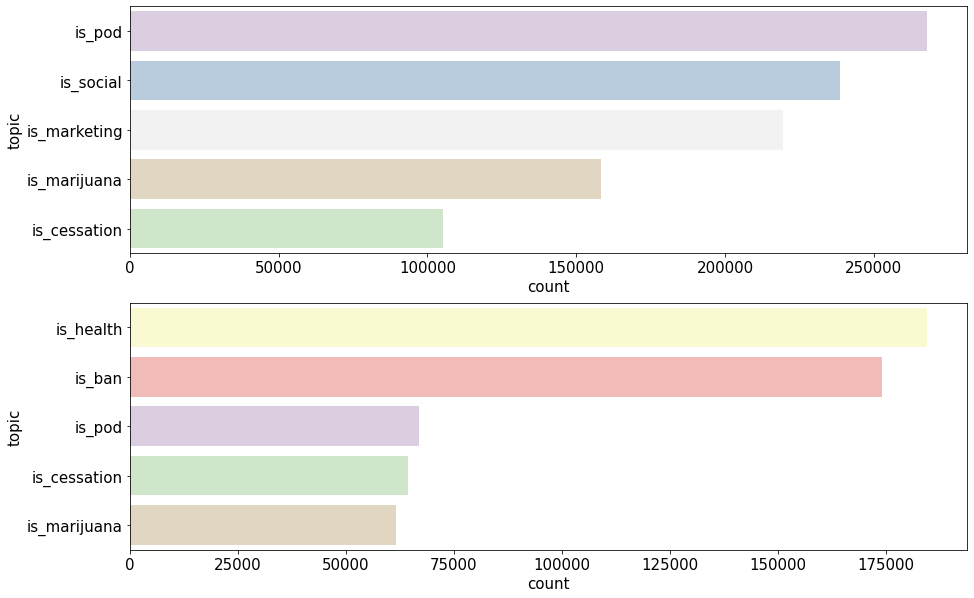

In [ ]:
#@title top ranked topics
plt.rcParams["figure.figsize"]=(15,10)
fig,axs=plt.subplots(nrows=2)
palette=dict(zip(list(interest_tweets_topics.drop('TweetID',axis='columns').columns),list(map(mpl.colors.rgb2hex,sns.color_palette('Pastel1',11).as_hex()))))
# sns.countplot(data=interest_tweets_topics,y='topic',orient='h',ax=axs[0],order=interest_tweets_topics['topic'].value_counts().iloc[:5].index,palette=palette)
sns.countplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==1][['TweetID']],interest_tweets_topics,on='TweetID'),y='topic',orient='h',ax=axs[0],order=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==1][['TweetID']],interest_tweets_topics,on='TweetID')['topic'].value_counts().iloc[:5].index,palette=palette)
sns.countplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==-1][['TweetID']],interest_tweets_topics,on='TweetID'),y='topic',orient='h',ax=axs[1],order=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==-1][['TweetID']],interest_tweets_topics,on='TweetID')['topic'].value_counts().iloc[:5].index,palette=palette)

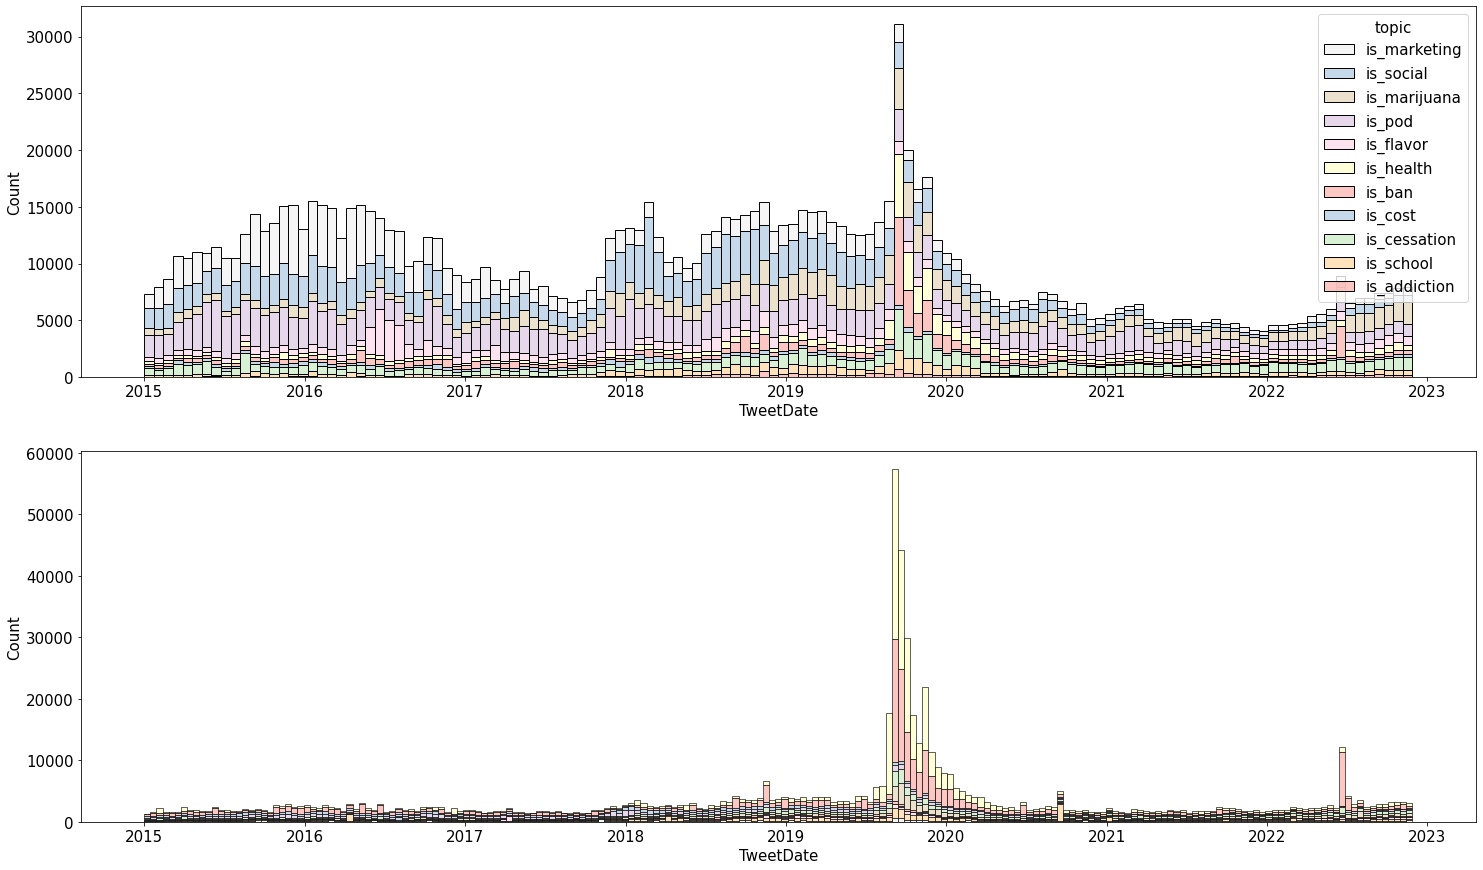

In [ ]:
#@title topics over time
plt.rcParams["figure.figsize"]=(25,15)
fig,axs=plt.subplots(nrows=2)
palette=dict(zip(list(interest_tweets_topics.drop('TweetID',axis='columns').columns),list(map(mpl.colors.rgb2hex,sns.color_palette('Pastel1',11).as_hex()))))
# sns.histplot(data=pd.merge(all_tweets_df[['TweetID','TweetDate']],interest_tweets_topics,on='TweetID'),x='TweetDate',hue='topic',multiple='stack',ax=axs[0],palette=palette)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==1][['TweetID','TweetDate']],interest_tweets_topics,on='TweetID'),x='TweetDate',hue='topic',multiple='stack',ax=axs[0],palette=palette)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==-1][['TweetID','TweetDate']],interest_tweets_topics,on='TweetID'),x='TweetDate',hue='topic',multiple='stack',ax=axs[1],legend=False,palette=palette)

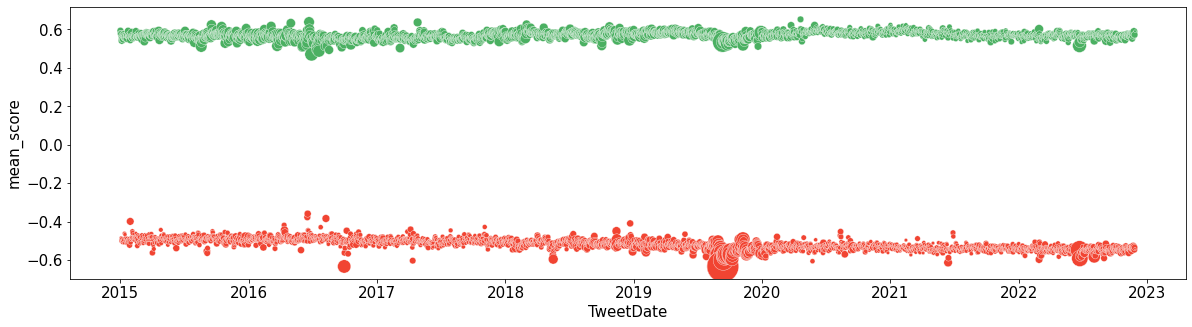

In [ ]:
#@title mean sentiment 
#@title sentiment over time
palette=dict(zip([1,0,-1],list(map(mpl.colors.rgb2hex,sns.color_palette('Greens',4).as_hex()))[2:3]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Greys',4).as_hex()))[1:2]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Reds',4).as_hex()))[2:3]))

rc = {'figure.figsize':(20,5),
      'axes.facecolor':'white',
      'font.size' : 15}
plt.rcParams.update(rc)

working_tweets=pd.merge(all_tweets_df.groupby(['TweetDate','VADER_sentiment_class'])['VADER_sentiment_score'].mean(),all_tweets_df.groupby(['TweetDate','VADER_sentiment_class'])['VADER_sentiment_score'].count(),on=['TweetDate','VADER_sentiment_class']).rename({'VADER_sentiment_score_x':'mean_score','VADER_sentiment_score_y':'sample_size'},axis='columns')
sns.scatterplot(data=working_tweets[working_tweets.index.get_level_values(1)!=0],x='TweetDate',y='mean_score',hue='VADER_sentiment_class',size='sample_size',sizes=(5,1000),palette=palette,legend=None)
# plt.legend(title='Sentiment',loc='upper left',labels=['Negative','Neutral','Positive'])
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

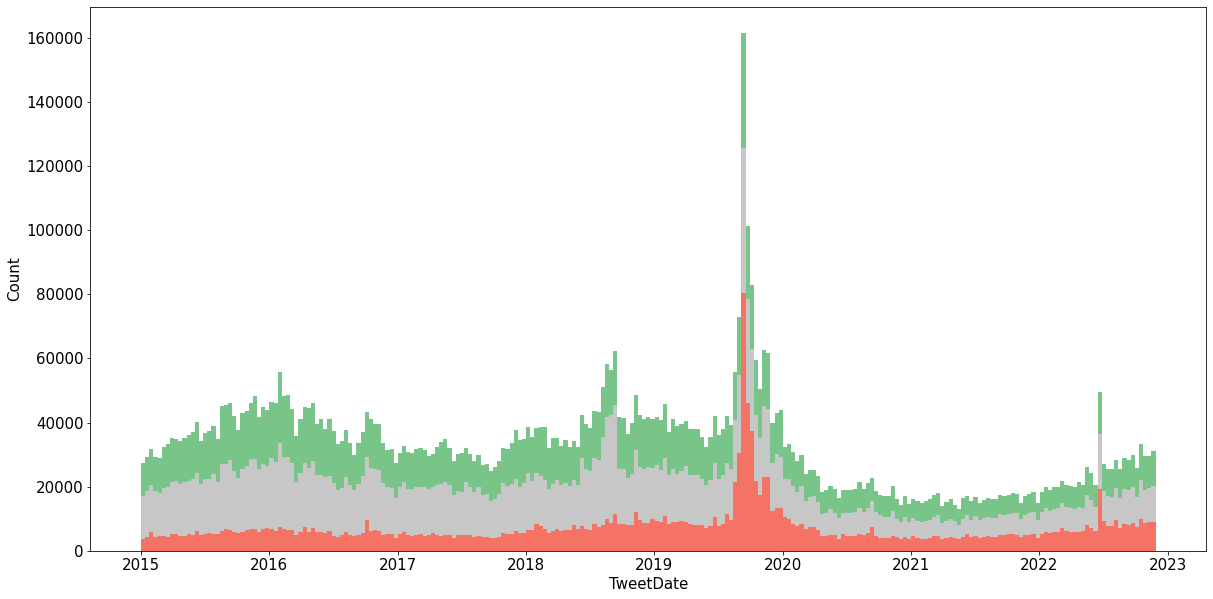

In [ ]:
#@title sentiment over time
palette=dict(zip([1,0,-1],list(map(mpl.colors.rgb2hex,sns.color_palette('Greens',4).as_hex()))[2:3]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Greys',4).as_hex()))[1:2]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Reds',4).as_hex()))[2:3]))

rc = {'figure.figsize':(20,10),
      'axes.facecolor':'white',
      'font.size' : 15}
plt.rcParams.update(rc)

sns.histplot(data=all_tweets_df,x='TweetDate',hue='VADER_sentiment_class',multiple='stack',palette=palette,hue_order=palette.keys(),edgecolor=None,legend=None)
# plt.legend(title='Sentiment',loc='upper left',labels=['Negative','Neutral','Positive'])
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

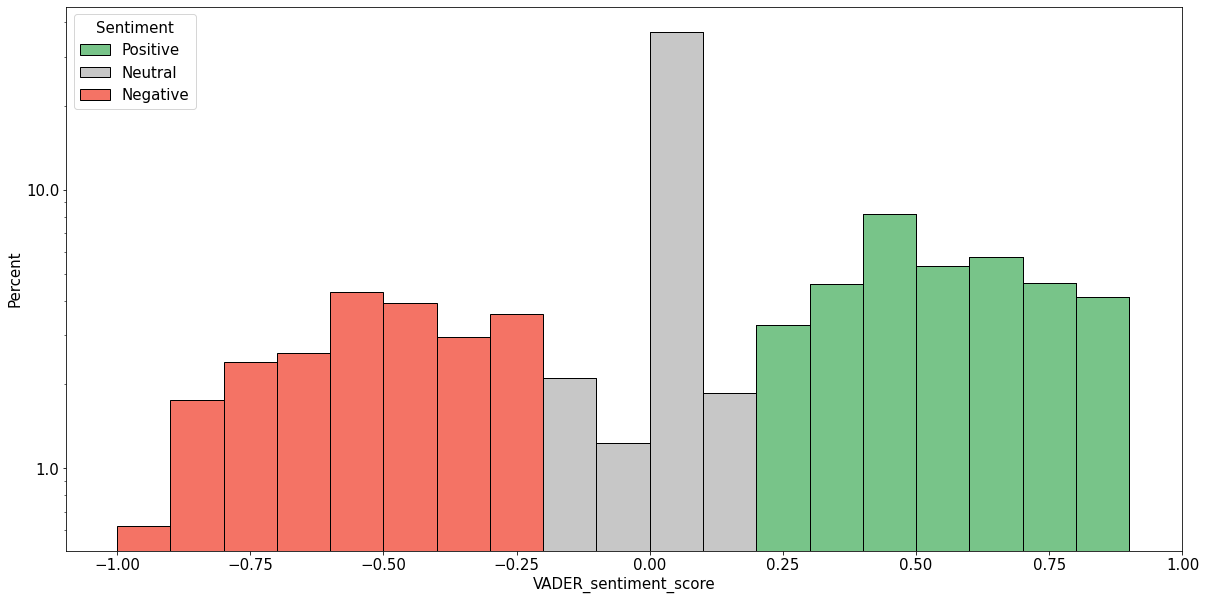

In [ ]:
#@title sentiment distribution
palette=dict(zip([1,0,-1],list(map(mpl.colors.rgb2hex,sns.color_palette('Greens',4).as_hex()))[2:3]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Greys',4).as_hex()))[1:2]+
             list(map(mpl.colors.rgb2hex,sns.color_palette('Reds',4).as_hex()))[2:3]))

rc = {'figure.figsize':(20,10),
      'axes.facecolor':'white',
      'font.size' : 15}
plt.rcParams.update(rc)

# tt=all_tweets_df.sample(10000).dropna()
# ax=sns.histplot(x=all_tweets_df['VADER_sentiment_score'].round(2),hue=all_tweets_df['VADER_sentiment_class'],palette=palette,stat='percent',bins=11,multiple='stack')
# ax=sns.histplot(x=all_tweets_df['VADER_sentiment_score'].round(2),hue=all_tweets_df['VADER_sentiment_class'],palette=palette,stat='percent',bins=[-1,-.8,-.6,-.4,-.200001,.200,.4,.6,.8,1],multiple='stack')
ax=sns.histplot(x=all_tweets_df['VADER_sentiment_score'],hue=all_tweets_df['VADER_sentiment_class'],palette=palette,stat='percent',bins=[x/10 for x in range(-10,10)],multiple='stack')
ax.set_yscale('log')

import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

plt.xticks([-1,-.75,-.5,-.25,0,.25,.5,.75,1])
plt.legend(title='Sentiment',loc='upper left',labels=['Positive','Neutral','Negative'])
# sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

In [ ]:
#@title emotions over time
bins=np.histogram_bin_edges(mdates.date2num(all_tweets_df['TweetDate']),bins='auto')
plt.rcParams["figure.figsize"]=(20,10)
fig,axs=plt.subplots(nrows=2)
gte=interest_tweets_emotions[interest_tweets_emotions['emotion_class'].isin(['joy','disgust','anger','fear','surprise','sadness','annoyance','amusement','grief','disapproval','confusion'])]
palette=dict(zip(
      ['joy','amusement']+['anger','annoyance']+['disgust','disapproval']+['fear']+['surprise','confusion']+['grief','sadness'],
      list(map(mpl.colors.rgb2hex,sns.color_palette('spring',4).as_hex()))[:2]+list(map(mpl.colors.rgb2hex,sns.color_palette('Reds',2).as_hex()))+list(map(mpl.colors.rgb2hex,sns.color_palette('Greens',2).as_hex()))+list(map(mpl.colors.rgb2hex,sns.color_palette('Purples',1).as_hex()))+list(map(mpl.colors.rgb2hex,sns.color_palette('Greys',2).as_hex()))+list(map(mpl.colors.rgb2hex,sns.color_palette('Blues',2).as_hex()))
  ))
# sns.histplot(data=pd.merge(all_tweets_df[['TweetID','TweetDate']],gte,on='TweetID'),x='TweetDate',hue='emotion_class',multiple='stack',ax=axs[0],palette=palette,hue_order=palette.keys(),bins=bins)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==1][['TweetID','TweetDate']],gte,on='TweetID'),x='TweetDate',hue='emotion_class',multiple='stack',ax=axs[0],palette=palette,hue_order=palette.keys(),bins=bins)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==-1][['TweetID','TweetDate']],gte,on='TweetID'),x='TweetDate',hue='emotion_class',multiple='stack',ax=axs[1],legend=False,palette=palette,hue_order=palette.keys(),bins=bins)

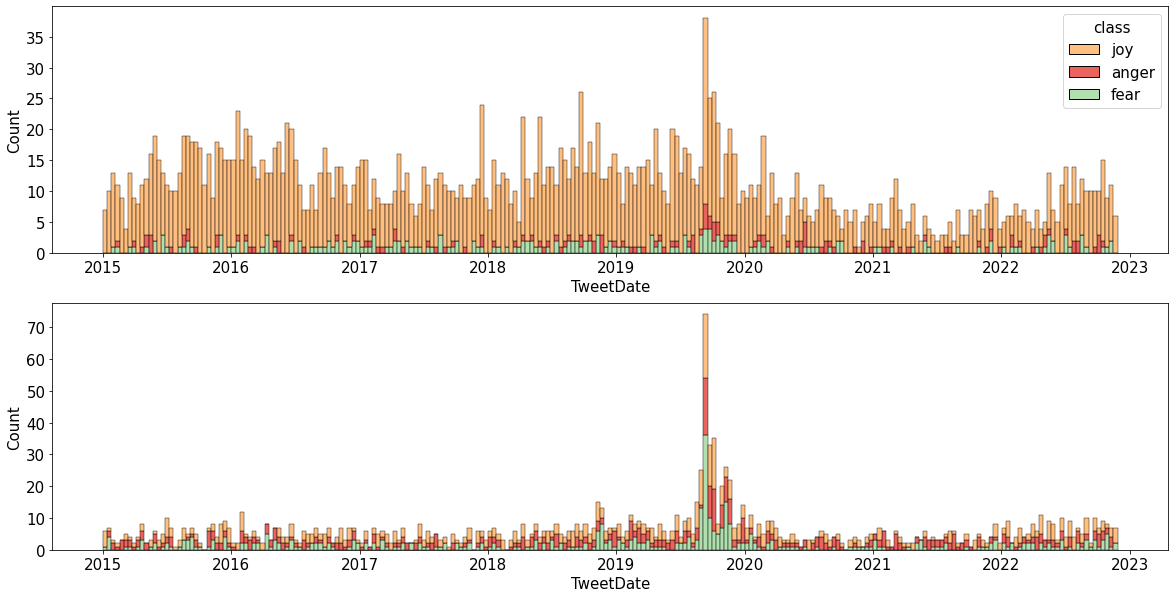

In [ ]:
#@title emotions over time
bins=np.histogram_bin_edges(mdates.date2num(all_tweets_df['TweetDate']),bins='auto')
plt.rcParams["figure.figsize"]=(20,10)
fig,axs=plt.subplots(nrows=2) 
gte=interest_tweets_emotions[interest_tweets_emotions['class'].isin(['joy','anger','fear','sadness'])]
palette=dict(zip(
      ['joy']+['anger']+['fear'],
      list(map(mpl.colors.rgb2hex,sns.color_palette('spring',2).as_hex()))[1:2]+list(map(mpl.colors.rgb2hex,sns.color_palette('Reds',2).as_hex()))[1:2]+list(map(mpl.colors.rgb2hex,sns.color_palette('Greens',4).as_hex()))[1:2]
  ))
# sns.histplot(data=pd.merge(all_tweets_df[['TweetID','TweetDate']],gte,on='TweetID'),x='TweetDate',hue='class',multiple='stack',ax=axs[0],bins=bins)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==1][['TweetID','TweetDate']],gte,on='TweetID'),x='TweetDate',hue='class',multiple='stack',ax=axs[0],palette=palette,hue_order=palette.keys(),bins=bins)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class']==-1][['TweetID','TweetDate']],gte,on='TweetID'),x='TweetDate',hue='class',multiple='stack',ax=axs[1],palette=palette,hue_order=palette.keys(),legend=False,bins=bins)

**WORKING**

In [ ]:
#@title pipeline

# original data I/O
res_df.to_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/OTS_complete_22_11_28.csv')
res_df['TweetDate']=res_df['TweetDatetime'].dt.strftime('%m-%d-%Y').astype("datetime64")

# dropping repeats
dropped_duplicates=res_df.sort_values('TweetDatetime',ascending=True).drop_duplicates('TweetContent',keep='first')

# text pre-processing
all_tweets_df['ProcessedContent']=all_tweets_df['TweetContent'].apply(lambda x:cleanText(x))
all_tweets_df['ProcessedContentVADER']=all_tweets_df['TweetContent'].apply(lambda x:cleanText(x,VADER=True))

# sentiment classification
all_tweets_df['VADER_sentiment_score']=all_tweets_df['ProcessedContentVADER'].apply(lambda x: classifyTextSentiment(str(x)))
all_tweets_df['VADER_sentiment_class']=all_tweets_df['VADER_sentiment_score'].apply(lambda x:1 if x>=.2 else -1 if x<=-.2 else 0)

# topic classification
interest_tweets_topics=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0][['TweetID']]
interest_tweets_topics['is_ban']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['ban','fda','banning','banned','trump']))
interest_tweets_topics['is_social']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['vapelife','vapefam','vapeon','vapenation','vapecommunity','vapeporn','vapelyfe','vapetricks','cloudchaser','vapedaily','vapefamily','vapestagram','vapelove','vapingtrain','vapepics']))
interest_tweets_topics['is_cessation']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['cigarette','smoking','quit','cigs','cig','smoker']) and sum(ss in str(x) for ss in ['quit','stop','switch','safer','alternative','healthier']))
interest_tweets_topics['is_pod']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['liquid','juice','eliquid','ejuice','ublo','bottle','vapeshop','vapejuice','jbrtvape','vapestore']))
interest_tweets_topics['is_school']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['school','teacher','college','campus','student','university']))
interest_tweets_topics['is_health']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['lung','illness','death','disease','cdc','injury','damage','outbreak','health']))
interest_tweets_topics['is_marijuana']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['cbd','cannabis','thc','marijuana','hemp','weed','edible','cannabiscommunity','herb','stoner','pax','indica','sativa']))
interest_tweets_topics['is_flavor']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['mango','apple','taste','candy','rain','sweet','cotton','flower','cherry','sour']))
interest_tweets_topics['is_marketing']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['giveaway','win','enter','chance','winner','vapegiveaway','prize','vapedeal','gift','competition','contest','entered']))
interest_tweets_topics['is_addiction']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['addicted','addiction','addictive']))
interest_tweets_topics['is_cost']=all_tweets_df[all_tweets_df['VADER_sentiment_class']!=0]['ProcessedContent'].apply(lambda x: sum(ss in str(x) for ss in ['cost','price','discount','premium','coupon','code']))
interest_tweets_topics['topic']=interest_tweets_topics.drop('TweetID',axis='columns').idxmax(axis='columns')
interest_tweets_topics['topic']=interest_tweets_topics.apply(lambda x: float('NaN') if x['topic']=='is_ban' and x['is_ban']==0 else x['topic'],axis='columns')

# emotion classification
all_tweets_df=pd.read_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/OTS_complete_22_11_30.csv',lineterminator='\n',parse_dates=['TweetDatetime','TweetDate'])
all_tweets_df=all_tweets_df.sample(250000)
all_tweets_df=all_tweets_df[['TweetID','TweetContent']]
all_tweets_df.to_csv('OTS_emotions.csv')

# emotion expansion
interest_tweets_emotions3=all_tweets_df[(all_tweets_df['VADER_sentiment_class']!=0)&(~all_tweets_df['TweetID'].isin(list(interest_tweets_emotions['TweetID'])))].sample(10000,random_state=520)[['TweetID']].reset_index()
interest_tweets_emotions3['emotion_class']=pd.merge(interest_tweets_emotions3,all_tweets_df[['TweetID','ProcessedContent']],on='TweetID')['ProcessedContent'].apply(lambda x:emotion(x)[0]['label'])
interest_tweets_emotions3['emotion_score']=pd.merge(interest_tweets_emotions3,all_tweets_df[['TweetID','ProcessedContent']],on='TweetID')['ProcessedContent'].apply(lambda x:emotion(x)[0]['score'])
interest_tweets_emotions=pd.concat([interest_tweets_emotions,interest_tweets_emotions2]).reset_index().drop(['level_0','index'],axis='columns')

# convert to ID list
res_df['TweetID']=res_df['TweetID'].apply(lambda x: '%.0f' % x)
temp=list(res_df['TweetID'].astype(str))
with open('RTS.txt','w') as f:
    for line in temp:
        f.write(f"{line}\n")

In [ ]:
#@title I/O
all_tweets_df=pd.read_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/OTS_complete_22_11_30.csv',lineterminator='\n',parse_dates=['TweetDatetime','TweetDate'])
interest_OTS=pd.read_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/OTS.csv',lineterminator='\n')
interest_tweets_topics=pd.read_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/topics_complete_22_12_2.csv',lineterminator='\n')
interest_tweets_emotions=pd.read_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/OTS_emotion_class.csv',lineterminator='\n')
interest_RTS=pd.read_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/RTS.csv',lineterminator='\n')

all_tweets_df.to_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/OTS_complete_22_11_30.csv',index=False)
res_df.to_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/RTS_complete_22_12_8.csv',index=False)
interest_tweets_topics.to_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/topics_complete_22_12_2.csv',index=False)
interest_tweets_emotions.to_csv('/content/drive/My Drive/HSR_Sarah Sun_Alex Xu_2023/Project/Data/emotions_complete_22_12_5.csv',index=False)/